### 1. 랜덤포레스트 분류분석

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("all_data4.csv", encoding='cp949')

df2 = df.fillna(0)
df2.head(2)

# 1. 경사도가 4 이상인 도로 사용
slope_up_four = df2[df2['sum'] >= 4]

# 2. UFID 따로 저장
ufid = slope_up_four['UFID']

# 3. 독립변수/종속변수 설정
X2 = slope_up_four.drop(columns=['UFID', 'heatline'])
y2 = slope_up_four['heatline']  # 종속변수는 Series로

# 4. StandardScaler 적용
scaler = StandardScaler()
X2_scaled = scaler.fit_transform(X2)

# 5. 훈련, 테스트셋 나누기 (UFID도 함께 분리)
X2_train, X2_test, y2_train, y2_test, ufid_train, ufid_test = train_test_split(
    X2_scaled, y2, ufid, test_size=0.3, random_state=0
)

# 6. 모델 정의 및 학습
model4 = RandomForestClassifier(random_state=0, class_weight='balanced')
model4.fit(X2_train, y2_train)

# 7. 예측 확률 계산
y2_probs = model4.predict_proba(X2_test)[:, 1]

# 8. threshold를 낮춰서 적극적으로 1로 분류
threshold = 0.2  # 매우 낮게 설정
y2_preds_custom = (y2_probs >= threshold).astype(int)

# 9. 결과 평가
print(classification_report(y2_test, y2_preds_custom))

# 1로 분류된 수 확인
print(f"1로 분류된 샘플 수: {np.sum(y2_preds_custom)} / {len(y2_preds_custom)}")

# -----------------------------
# 10. 열선 제외 + 경사도 6 이상인 도로 선택
df2_unlabeled = df2[(df2['heatline'] != 1) & (df2['sum'] >= 6)]

# 11. UFID 저장
ufid_unlabeled = df2_unlabeled['UFID']

# 12. 독립변수 생성
X_unlabeled = df2_unlabeled.drop(columns=['UFID', 'heatline'])

# 13. unlabeled 데이터도 스케일링 적용
X_unlabeled_scaled = scaler.transform(X_unlabeled)

# 14. 모델 예측
y_unlabeled_predict = model4.predict_proba(X_unlabeled_scaled)[:, 1]

# 15. 임계값 적용
threshold = 0.2
y_unlabeled_preds = (y_unlabeled_predict >= threshold).astype(int)

# 16. 결과를 데이터프레임으로 저장
unlabeled_result_df = pd.DataFrame({
    'UFID': ufid_unlabeled.values,
    'heatline_pred': y_unlabeled_preds
})

# 최종 결과 확인
unlabeled_result_df

              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93       580
         1.0       0.35      0.48      0.41        54

    accuracy                           0.88       634
   macro avg       0.65      0.70      0.67       634
weighted avg       0.90      0.88      0.89       634

1로 분류된 샘플 수: 74 / 634


,UFID,heatline_pred
0,1000037705073A00110000000000003171,0
1,1000037705073A00110000000000003175,0
2,1000037705073A00110000000000003176,0
3,1000037705073A00110000000000003278,0
4,1000037705073A00110000000000003344,0
...,...,...
1028,1000037705085A00110000000000004961,0
1029,1000037705085A00110000000000004962,0
1030,1000037705085A00110000000000004963,0
1031,1000037705085A00110000000000004964,0


## 랜덤포레스트 결과
랜덤포레스트 기본 파라미터로 튜닝한 결과 열선 설치구역을 제대로 맞춘 정확도는 0.35로 나타났다.

      Feature  Importance
0         sum    0.575173
1         val    0.358528
2  kinder_cou    0.038622
3  school_cou    0.027676


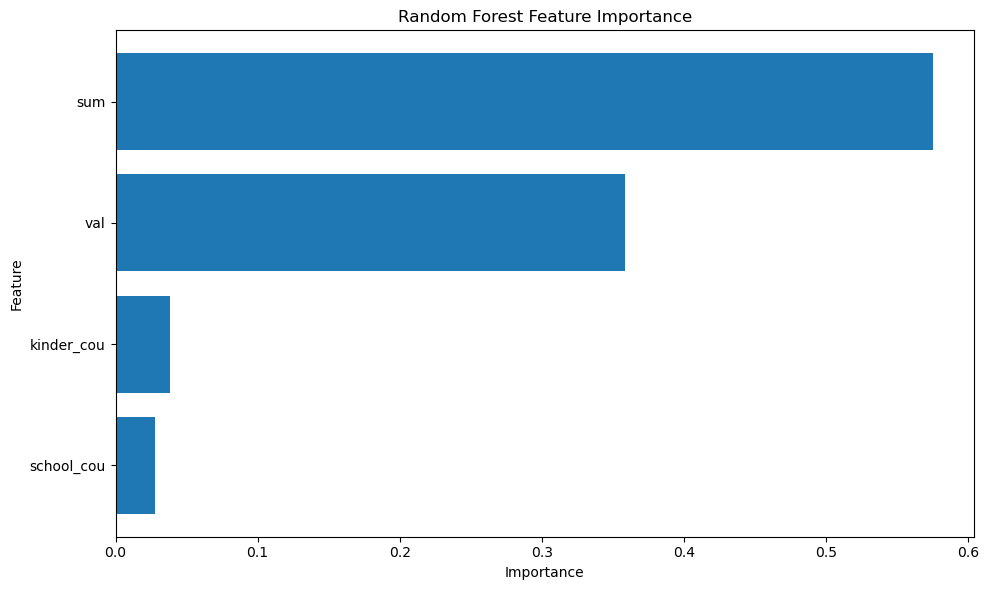

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# feature importance 추출
importances = rf_model.feature_importances_
feature_names = rf_X.columns

# 데이터프레임으로 정리
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 중요도 내림차순 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(feature_importance_df)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()  # 가장 중요한 변수가 위로
plt.tight_layout()
plt.show()


### 하이퍼파라미터 튜닝

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# 데이터 로드
rf_df = pd.read_csv("all_data4.csv", encoding='cp949')

# 결측값 처리
rf_df_cleaned = rf_df.fillna(0)

# 경사도 4 이상 도로 선택
rf_slope_filtered = rf_df_cleaned[rf_df_cleaned['sum'] >= 4]

# UFID 저장
rf_ufid = rf_slope_filtered['UFID']

# 독립변수/종속변수 설정
rf_X = rf_slope_filtered.drop(columns=['UFID', 'heatline'])
rf_y = rf_slope_filtered['heatline']

# 스케일링
rf_scaler = StandardScaler()
rf_X_scaled = rf_scaler.fit_transform(rf_X)

# 데이터 분할
rf_X_train, rf_X_test, rf_y_train, rf_y_test, rf_ufid_train, rf_ufid_test = train_test_split(
    rf_X_scaled, rf_y, rf_ufid, test_size=0.3, random_state=0
)

# 랜덤포레스트 하이퍼파라미터 탐색 공간
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced']
}

# RandomizedSearchCV 설정
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=0),
    param_distributions=param_dist,
    n_iter=30,  # 탐색할 파라미터 조합 개수
    cv=3,
    verbose=2,
    random_state=0,
    n_jobs=-1
)

# 탐색 실행
rf_random_search.fit(rf_X_train, rf_y_train)

# 최적 모델
best_rf_model = rf_random_search.best_estimator_
print(f"최적 하이퍼파라미터:\n{rf_random_search.best_params_}")

# 테스트셋 예측
rf_y_probs = best_rf_model.predict_proba(rf_X_test)[:, 1]

# 임계값 적용
rf_threshold = 0.2
rf_y_preds_custom = (rf_y_probs >= rf_threshold).astype(int)

# 평가
print(classification_report(rf_y_test, rf_y_preds_custom))
print(f"1로 분류된 샘플 수: {np.sum(rf_y_preds_custom)} / {len(rf_y_preds_custom)}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
최적 하이퍼파라미터:
{'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': None, 'bootstrap': True}
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93       580
         1.0       0.34      0.56      0.43        54

    accuracy                           0.87       634
   macro avg       0.65      0.73      0.68       634
weighted avg       0.90      0.87      0.89       634

1로 분류된 샘플 수: 87 / 634


### 하이퍼 파라미터 튜닝이 완료된 모델의 변수 중요도

      Feature  Importance
0         sum    0.527811
3         val    0.406842
1  kinder_cou    0.033626
2  school_cou    0.031721


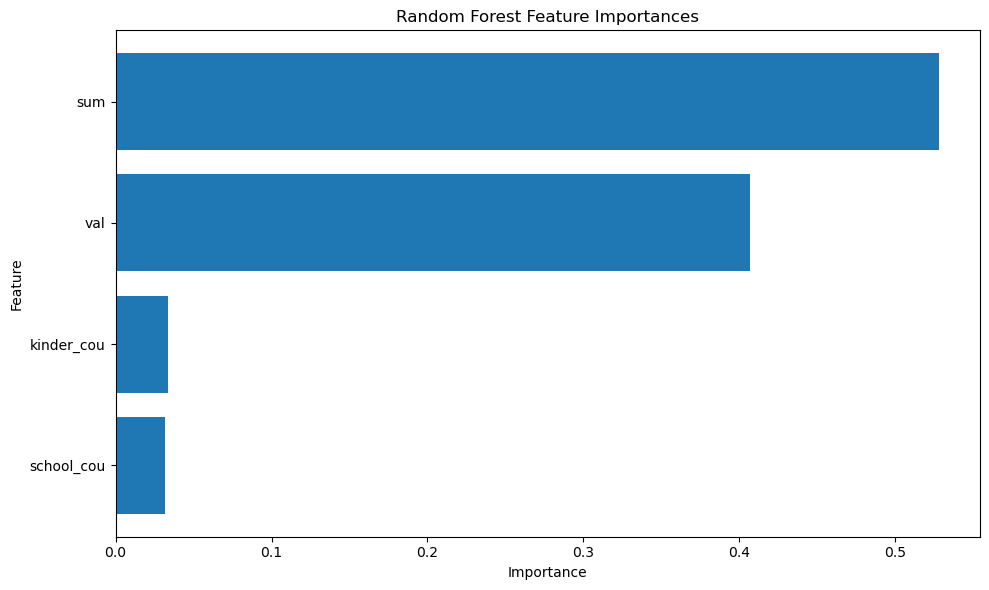

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 변수 이름
feature_names = rf_X.columns

# 중요도 값 추출
importances = best_rf_model.feature_importances_

# 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 중요도 출력
print(importance_df)

# 시각화
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()  # 중요도 높은 게 위로 오게
plt.tight_layout()
plt.show()


### 데이터 내보내기
하이퍼파라미터 튜닝이 완료된 모델로 열선과 경사도가 6이상인 도로에서 예측값을 탐색

In [16]:
# 1. 열선 제외 + 경사도 6 이상 도로 선택
df2_unlabeled = rf_df_cleaned[(rf_df_cleaned['heatline'] != 1) & (rf_df_cleaned['sum'] >= 6)]

# 2. UFID 저장
ufid_unlabeled = df2_unlabeled['UFID']

# 3. 독립변수 생성
X_unlabeled = df2_unlabeled.drop(columns=['UFID', 'heatline'])

# 4. 스케일링 적용 (훈련 시 사용한 scaler 그대로)
X_unlabeled_scaled = rf_scaler.transform(X_unlabeled)

# 5. 예측 확률 계산
y_unlabeled_probs = best_rf_model.predict_proba(X_unlabeled_scaled)[:, 1]

# 6. 임계값 적용
rf_threshold = 0.2
y_unlabeled_preds = (y_unlabeled_probs >= rf_threshold).astype(int)

# 7. 결과를 데이터프레임으로 저장
unlabeled_result_df = pd.DataFrame({
    'UFID': ufid_unlabeled.values,
    'heatline_pred': y_unlabeled_preds,
    'predicted_probability': y_unlabeled_probs
})

# 8. CSV로 저장
unlabeled_result_df.to_csv("predicted_heatline_roads_best_rf.csv", index=False, encoding='utf-8-sig')

print("✅ 예측 결과가 'predicted_heatline_roads_best_rf.csv'로 저장되었습니다.")

✅ 예측 결과가 'predicted_heatline_roads_best_rf.csv'로 저장되었습니다.


## XGBoost 분류 분석

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# 데이터 로드
xgb_df = pd.read_csv("all_data4.csv", encoding='cp949')

# 결측값 처리
xgb_df_cleaned = xgb_df.fillna(0)

# 경사도 4 이상 도로 선택
xgb_slope_filtered = xgb_df_cleaned[xgb_df_cleaned['sum'] >= 4]

# UFID 저장
xgb_ufid = xgb_slope_filtered['UFID']

# 독립변수/종속변수 설정
xgb_X = xgb_slope_filtered.drop(columns=['UFID', 'heatline'])
xgb_y = xgb_slope_filtered['heatline']

# 스케일링
xgb_scaler = StandardScaler()
xgb_X_scaled = xgb_scaler.fit_transform(xgb_X)

# 데이터 분할
xgb_X_train, xgb_X_test, xgb_y_train, xgb_y_test, xgb_ufid_train, xgb_ufid_test = train_test_split(
    xgb_X_scaled, xgb_y, xgb_ufid, test_size=0.3, random_state=0
)

# XGBoost 모델 정의 및 학습
xgb_model = XGBClassifier(random_state=0, scale_pos_weight=(xgb_y == 0).sum() / (xgb_y == 1).sum(), use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(xgb_X_train, xgb_y_train)

# 예측 확률 계산
xgb_y_probs = xgb_model.predict_proba(xgb_X_test)[:, 1]

# 임계값 적용
xgb_threshold = 0.2
xgb_y_preds_custom = (xgb_y_probs >= xgb_threshold).astype(int)

# 평가
print(classification_report(xgb_y_test, xgb_y_preds_custom))
print(f"1로 분류된 샘플 수: {np.sum(xgb_y_preds_custom)} / {len(xgb_y_preds_custom)}")

# 열선 제외 + 경사도 6 이상 도로
xgb_unlabeled = xgb_df_cleaned[(xgb_df_cleaned['heatline'] != 1) & (xgb_df_cleaned['sum'] >= 6)]
xgb_ufid_unlabeled = xgb_unlabeled['UFID']
xgb_X_unlabeled = xgb_unlabeled.drop(columns=['UFID', 'heatline'])
xgb_X_unlabeled_scaled = xgb_scaler.transform(xgb_X_unlabeled)

# 예측
xgb_y_unlabeled_predict = xgb_model.predict_proba(xgb_X_unlabeled_scaled)[:, 1]
xgb_y_unlabeled_preds = (xgb_y_unlabeled_predict >= xgb_threshold).astype(int)

# 결과 저장
xgb_unlabeled_result_df = pd.DataFrame({
    'UFID': xgb_ufid_unlabeled.values,
    'heatline_pred': xgb_y_unlabeled_preds
})

xgb_unlabeled_result_df

C:\Users\gkdis\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:43:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92       580
         1.0       0.28      0.44      0.35        54

    accuracy                           0.86       634
   macro avg       0.61      0.67      0.63       634
weighted avg       0.89      0.86      0.87       634

1로 분류된 샘플 수: 85 / 634


,UFID,heatline_pred
0,1000037705073A00110000000000003171,0
1,1000037705073A00110000000000003175,0
2,1000037705073A00110000000000003176,0
3,1000037705073A00110000000000003278,0
4,1000037705073A00110000000000003344,1
...,...,...
1028,1000037705085A00110000000000004961,0
1029,1000037705085A00110000000000004962,0
1030,1000037705085A00110000000000004963,0
1031,1000037705085A00110000000000004964,0


## 로지스틱 회귀분석

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# 데이터 로드
logit_df = pd.read_csv("all_data4.csv", encoding='cp949')

# 결측값 처리
logit_df_cleaned = logit_df.fillna(0)

# 경사도 4 이상 도로 선택
logit_slope_filtered = logit_df_cleaned[logit_df_cleaned['sum'] >= 4]

# UFID 저장
logit_ufid = logit_slope_filtered['UFID']

# 독립변수/종속변수 설정
logit_X = logit_slope_filtered.drop(columns=['UFID', 'heatline'])
logit_y = logit_slope_filtered['heatline']

# 스케일링
logit_scaler = StandardScaler()
logit_X_scaled = logit_scaler.fit_transform(logit_X)

# 데이터 분할
logit_X_train, logit_X_test, logit_y_train, logit_y_test, logit_ufid_train, logit_ufid_test = train_test_split(
    logit_X_scaled, logit_y, logit_ufid, test_size=0.3, random_state=0
)

# 로지스틱 회귀 모델 정의 및 학습
logit_model = LogisticRegression(random_state=0, class_weight='balanced', max_iter=1000)
logit_model.fit(logit_X_train, logit_y_train)

# 예측 확률 계산
logit_y_probs = logit_model.predict_proba(logit_X_test)[:, 1]

# 임계값 적용
logit_threshold = 0.2
logit_y_preds_custom = (logit_y_probs >= logit_threshold).astype(int)

# 평가
print(classification_report(logit_y_test, logit_y_preds_custom))
print(f"1로 분류된 샘플 수: {np.sum(logit_y_preds_custom)} / {len(logit_y_preds_custom)}")

# 열선 제외 + 경사도 6 이상 도로
logit_unlabeled = logit_df_cleaned[(logit_df_cleaned['heatline'] != 1) & (logit_df_cleaned['sum'] >= 6)]
logit_ufid_unlabeled = logit_unlabeled['UFID']
logit_X_unlabeled = logit_unlabeled.drop(columns=['UFID', 'heatline'])
logit_X_unlabeled_scaled = logit_scaler.transform(logit_X_unlabeled)

# 예측
logit_y_unlabeled_predict = logit_model.predict_proba(logit_X_unlabeled_scaled)[:, 1]
logit_y_unlabeled_preds = (logit_y_unlabeled_predict >= logit_threshold).astype(int)

# 결과 저장
logit_unlabeled_result_df = pd.DataFrame({
    'UFID': logit_ufid_unlabeled.values,
    'heatline_pred': logit_y_unlabeled_preds
})

logit_unlabeled_result_df


              precision    recall  f1-score   support

         0.0       1.00      0.08      0.15       580
         1.0       0.09      1.00      0.17        54

    accuracy                           0.16       634
   macro avg       0.55      0.54      0.16       634
weighted avg       0.92      0.16      0.15       634

1로 분류된 샘플 수: 587 / 634


,UFID,heatline_pred
0,1000037705073A00110000000000003171,1
1,1000037705073A00110000000000003175,1
2,1000037705073A00110000000000003176,1
3,1000037705073A00110000000000003278,1
4,1000037705073A00110000000000003344,1
...,...,...
1028,1000037705085A00110000000000004961,1
1029,1000037705085A00110000000000004962,1
1030,1000037705085A00110000000000004963,1
1031,1000037705085A00110000000000004964,1


## Catboost

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

# 데이터 로드
catboost_df = pd.read_csv("all_data4.csv", encoding='cp949')

# 결측값 처리
catboost_df_cleaned = catboost_df.fillna(0)

# 경사도 4 이상 도로 선택
catboost_slope_filtered = catboost_df_cleaned[catboost_df_cleaned['sum'] >= 4]

# UFID 저장
catboost_ufid = catboost_slope_filtered['UFID']

# 독립변수/종속변수 설정
catboost_X = catboost_slope_filtered.drop(columns=['UFID', 'heatline'])
catboost_y = catboost_slope_filtered['heatline']

# 스케일링 (CatBoost는 사실 스케일링 필요 없음, 하지만 다른 모델과 맞추려면 해도 OK)
catboost_scaler = StandardScaler()
catboost_X_scaled = catboost_scaler.fit_transform(catboost_X)

# 데이터 분할
catboost_X_train, catboost_X_test, catboost_y_train, catboost_y_test, catboost_ufid_train, catboost_ufid_test = train_test_split(
    catboost_X_scaled, catboost_y, catboost_ufid, test_size=0.3, random_state=0
)

# CatBoost 모델 정의 및 학습 (silent=True로 학습 로그 끄기)
catboost_model = CatBoostClassifier(random_state=0, auto_class_weights='Balanced', verbose=False)
catboost_model.fit(catboost_X_train, catboost_y_train)

# 예측 확률 계산
catboost_y_probs = catboost_model.predict_proba(catboost_X_test)[:, 1]

# 임계값 적용
catboost_threshold = 0.2
catboost_y_preds_custom = (catboost_y_probs >= catboost_threshold).astype(int)

# 평가
print(classification_report(catboost_y_test, catboost_y_preds_custom))
print(f"1로 분류된 샘플 수: {np.sum(catboost_y_preds_custom)} / {len(catboost_y_preds_custom)}")

# 열선 제외 + 경사도 6 이상 도로
catboost_unlabeled = catboost_df_cleaned[(catboost_df_cleaned['heatline'] != 1) & (catboost_df_cleaned['sum'] >= 6)]
catboost_ufid_unlabeled = catboost_unlabeled['UFID']
catboost_X_unlabeled = catboost_unlabeled.drop(columns=['UFID', 'heatline'])
catboost_X_unlabeled_scaled = catboost_scaler.transform(catboost_X_unlabeled)

# 예측
catboost_y_unlabeled_predict = catboost_model.predict_proba(catboost_X_unlabeled_scaled)[:, 1]
catboost_y_unlabeled_preds = (catboost_y_unlabeled_predict >= catboost_threshold).astype(int)

# 결과 저장
catboost_unlabeled_result_df = pd.DataFrame({
    'UFID': catboost_ufid_unlabeled.values,
    'heatline_pred': catboost_y_unlabeled_preds
})

catboost_unlabeled_result_df


              precision    recall  f1-score   support

         0.0       0.98      0.67      0.80       580
         1.0       0.19      0.83      0.31        54

    accuracy                           0.69       634
   macro avg       0.58      0.75      0.56       634
weighted avg       0.91      0.69      0.76       634

1로 분류된 샘플 수: 234 / 634


,UFID,heatline_pred
0,1000037705073A00110000000000003171,0
1,1000037705073A00110000000000003175,0
2,1000037705073A00110000000000003176,0
3,1000037705073A00110000000000003278,0
4,1000037705073A00110000000000003344,1
...,...,...
1028,1000037705085A00110000000000004961,0
1029,1000037705085A00110000000000004962,0
1030,1000037705085A00110000000000004963,0
1031,1000037705085A00110000000000004964,1


### LightGBM

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

# 데이터 로드
lgbm_df = pd.read_csv("all_data4.csv", encoding='cp949')

# 결측값 처리
lgbm_df_cleaned = lgbm_df.fillna(0)

# 경사도 4 이상 도로 선택
lgbm_slope_filtered = lgbm_df_cleaned[lgbm_df_cleaned['sum'] >= 4]

# UFID 저장
lgbm_ufid = lgbm_slope_filtered['UFID']

# 독립변수/종속변수 설정
lgbm_X = lgbm_slope_filtered.drop(columns=['UFID', 'heatline'])
lgbm_y = lgbm_slope_filtered['heatline']

# 스케일링 (LightGBM은 원래 필요 없지만, 다른 모델들과 통일성을 위해 유지)
lgbm_scaler = StandardScaler()
lgbm_X_scaled = lgbm_scaler.fit_transform(lgbm_X)

# 데이터 분할
lgbm_X_train, lgbm_X_test, lgbm_y_train, lgbm_y_test, lgbm_ufid_train, lgbm_ufid_test = train_test_split(
    lgbm_X_scaled, lgbm_y, lgbm_ufid, test_size=0.3, random_state=0
)

# LightGBM 모델 정의 및 학습
lgbm_model = lgb.LGBMClassifier(
    random_state=0,
    is_unbalance=True,  # 불균형 클래스 보정
    n_estimators=100,
    learning_rate=0.1
)
lgbm_model.fit(lgbm_X_train, lgbm_y_train)

# 예측 확률 계산
lgbm_y_probs = lgbm_model.predict_proba(lgbm_X_test)[:, 1]

# 임계값 적용
lgbm_threshold = 0.2
lgbm_y_preds_custom = (lgbm_y_probs >= lgbm_threshold).astype(int)

# 평가
print(classification_report(lgbm_y_test, lgbm_y_preds_custom))
print(f"1로 분류된 샘플 수: {np.sum(lgbm_y_preds_custom)} / {len(lgbm_y_preds_custom)}")


C:\Users\gkdis\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.95      0.88      0.91       580
         1.0       0.29      0.54      0.37        54

    accuracy                           0.85       634
   macro avg       0.62      0.71      0.64       634
weighted avg       0.90      0.85      0.87       634

1로 분류된 샘플 수: 101 / 634


C:\Users\gkdis\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
##### import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# 데이터 로드
adaboost_df = pd.read_csv("all_data4.csv", encoding='cp949')

# 결측값 처리
adaboost_df_cleaned = adaboost_df.fillna(0)

# 경사도 4 이상 도로 선택
adaboost_slope_filtered = adaboost_df_cleaned[adaboost_df_cleaned['sum'] >= 4]

# UFID 저장
adaboost_ufid = adaboost_slope_filtered['UFID']

# 독립변수/종속변수 설정
adaboost_X = adaboost_slope_filtered.drop(columns=['UFID', 'heatline'])
adaboost_y = adaboost_slope_filtered['heatline']

# 스케일링 (AdaBoost는 트리 기반이라 필요 없지만, 비교용으로 유지)
adaboost_scaler = StandardScaler()
adaboost_X_scaled = adaboost_scaler.fit_transform(adaboost_X)

# 데이터 분할
adaboost_X_train, adaboost_X_test, adaboost_y_train, adaboost_y_test, adaboost_ufid_train, adaboost_ufid_test = train_test_split(
    adaboost_X_scaled, adaboost_y, adaboost_ufid, test_size=0.3, random_state=0
)

# AdaBoost 모델 정의 및 학습 (기본 약한 학습기는 깊이 1인 결정트리)
adaboost_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0,
    random_state=0
)
adaboost_model.fit(adaboost_X_train, adaboost_y_train)

# 예측 확률 계산
adaboost_y_probs = adaboost_model.predict_proba(adaboost_X_test)[:, 1]

# 임계값 적용
adaboost_threshold = 0.2
adaboost_y_preds_custom = (adaboost_y_probs >= adaboost_threshold).astype(int)

# 평가
print(classification_report(adaboost_y_test, adaboost_y_preds_custom))
print(f"1로 분류된 샘플 수: {np.sum(adaboost_y_preds_custom)} / {len(adaboost_y_preds_custom)}")
